# Regression Model on RDD(v2)
### 1) RandomForest
### 2) Gradient-Boosted Tree
### 3) NaiveBays
### 4) Isotonic Regression

### 0) Previous Settings

In [13]:
%pylab inline

import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

raw_data=sc.textFile("/home/csxion/Desktop/project/data/p9_data_11_16_1q_sed.csv")
records=raw_data.map(lambda line:line.split(","))
records.first()

subway_dict=records.map(lambda r:r[0]).distinct().zipWithIndex().collectAsMap() # distinct 꼭 사용할 것
time_dict=records.map(lambda r:r[2]).distinct().zipWithIndex().collectAsMap()
#date_dict=records.map(lambda r:r[1]).distinct().zipWithIndex().collectAsMap()

# r[0] : subway station name // Category feature => binary vector
# r[1] : Date(Not used)
# r[2] : Time(5~23) # Category feature => binary vector

def check_error_float(data, econd, subt): #data가 equal_cond와 같을때, subt로 치환한다.
    if(data==econd):
        return subt
    else:
        return float(data)

def extract_features_linear(r): #line별
    name_vec=np.zeros(len(subway_dict)) # 역 이름에 대하여 카테고리 특징을 바이너리 벡터 형태로 변환한다.
    name_vec[subway_dict[r[0]]]=1
    time_vec=np.zeros(len(time_dict)) # 시간 데이터에 대하여(5~23) 카테고리 특징을 바이너리 벡터 형태로 변환한다.
    time_vec[time_dict[r[2]]]=1
    #numbers=np.array([float(r[i]) for i in range(3,len(r)-1)])
    #numbers=np.array([float(e) for e in r[3:]])
    for i in range(3,len(r)-1):
        r[i]=check_error_float(r[i], "#N/A", 0.0)
    numbers=np.array([float(d) for d in r[3:len(r)-1]])
    return np.concatenate((name_vec, time_vec, numbers)) # 역 + 시간 + 특징벡터 값으로 구성되는 numpy.array를 반환한다.
#flatMap을 사용할 필요가 없음

def extract_label(r):
    return float(r[len(r)-1]) # int는 소문자로 지정해야 함
#float

def extract_features_dt(r): # dt모델에 적용할 특징벡터를 추출하는 함수. 여기서는 바이너리 벡터를 생성하지 않는다.
    name=float(subway_dict[r[0]])
    time=float(time_dict[r[2]])
    for i in range(3,len(r)-1):
        r[i]=check_error_float(r[i], "#N/A", 0.0)
    numbers=np.array([float(d) for d in r[3:len(r)-1]])
    return np.concatenate((np.array([name, time]), numbers))

# np.concatenate 함수는 꼭 이중괄호를 해주어야 index 에러가 나지 않는다.
# extract_label 함수의 경우 linearRegression Model과 DecisionTree 모두 동일하게 사용한다

def squared_error(actual, pred):
    return (actual-pred)**2
def abs_error(actual,pred):
    return np.abs(actual-pred)
def squared_log_error(actual, pred):
    return (np.log(pred+1)-np.log(actual+1))**2

Populating the interactive namespace from numpy and matplotlib


In [19]:
data=records.map(lambda r:LabeledPoint(extract_label(r), Vectors.dense(np.array(extract_features_linear(r)))))
data.cache

(train_data, test_data) = data.randomSplit([0.7, 0.3]) #training Data와 Test Data를 7 : 3의 비율로 나눈다
train_data.cache
test_data.cache

<bound method RDD.cache of PythonRDD[613] at RDD at PythonRDD.scala:48>

In [15]:
data.first()

LabeledPoint(78.0, [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077606673,0.420556606,0.414592146,0.820293973,0.553426589,0.549782942,0.99369488])

In [16]:
#LinearRegression 모델 테스트 메소드
"""
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp=test.map(lambda p:(p.label, model.predict(p.features)))
    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())
    return rmsle
"""

'\ndef evaluate(train, test, iterations, step, regParam, regType, intercept):\n    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)\n    tp=test.map(lambda p:(p.label, model.predict(p.features)))\n    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())\n    return rmsle\n'

## 1) RandomForest Model based RDD
- 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성
- 부트스트랩 샘플에 임의성을 더함
- 랜덤포레스트를 사용하게 되면 더 이상 어떤 과정을 통해 예측이 이뤄지는 지 알 수 없음(DT에서는 확인 가능)
- 여러 개의 의사결정트리를 만들고, 투표를 시켜 다수결로 결과를 확인

##### Bagging(Bootstrap Aggregation)
- Bagging은 Bias-Variance trade off 를 해결하기 위한 방법
- 전체 데이터를 전부 이용해서 학습시키는 것이 아니라 샘플의 결과물을 각 트리의 입력 값으로 넣어 학습
- (Bias : 예측의 정확도, Variance : 예측의 정확도가 들쭉날쭉하는 정도. 한쪽이 높아지면 한쪽이 낮아지는 관계)
- 데이터셋에서 랜덤하게 부분데이터를 뽑아 여러개의 데이터 subset으로 bias를 decision tree의 평균값으로 유지하면서도 variance를 줄이는 방법

##### Variable Randomize(Ensemble Learning)
- 파티션을 나눌 때 변수에 랜덤성을 부여
- 남아있는 모든 변수 중에서 최적의 변수를 선택하는 것이 아니라 변수 중 일부만 선택하고 그 일부 중에서 최적의 변수를 선택



[참고] Mycloud http://swalloow.tistory.com/92
[참고] 위키백과 https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8

##### .trainRegressor(data, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='variance', maxDepth=4, maxBins=32, seed=None)[source]
##### Parameters:	
* data – Training dataset: RDD of LabeledPoint. Labels are real numbers.
* categoricalFeaturesInfo – Map storing arity of categorical features. An entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
* numTrees – Number of trees in the random forest.
* featureSubsetStrategy – Number of features to consider for splits at each node. Supported values: “auto”, “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “onethird” for regression. (default: “auto”)
* impurity – Criterion used for information gain calculation. The only supported value for regression is “variance”. (default: “variance”)
* maxDepth – Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). (default: 4)
* maxBins – Maximum number of bins used for splitting features. (default: 32)
* seed – Random seed for bootstrapping and choosing feature subsets. Set as None to generate seed based on system time. (default: None)

### 1-1) RandomForest Test code

In [17]:
# http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model = RandomForest.trainRegressor(data, categoricalFeaturesInfo={},
                                    numTrees=3, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=4, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(data.map(lambda x: x.features))
labelsAndPredictions = data.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda p: (p[0] - p[1]) * (p[0] - p[1])).sum() /\
float(data.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression forest model:')
print(model.toDebugString()) # 새로운걸 확인할 수 있었음

# Save and load model
##model.save(sc, "target/tmp/myRandomForestRegressionModel")
##sameModel = RandomForestModel.load(sc, "target/tmp/myRandomForestRegressionModel")


Test Mean Squared Error = 6671220.357082351
Learned regression forest model:
TreeEnsembleModel regressor with 3 trees

  Tree 0:
    If (feature 44 <= 0.0)
     If (feature 121 <= 0.0)
      If (feature 122 <= 0.0)
       If (feature 58 <= 0.0)
        Predict: 2693.6871696873786
       Else (feature 58 > 0.0)
        Predict: 7738.7865771812085
      Else (feature 122 > 0.0)
       If (feature 15 <= 0.0)
        Predict: 334.51809742359444
       Else (feature 15 > 0.0)
        Predict: 1624.6451612903227
     Else (feature 121 > 0.0)
      If (feature 53 <= 0.0)
       If (feature 58 <= 0.0)
        Predict: 4768.405135951662
       Else (feature 58 > 0.0)
        Predict: 15172.569892473119
      Else (feature 53 > 0.0)
       If (feature 132 <= 0.817630849)
        Predict: 20259.38
       Else (feature 132 > 0.817630849)
        Predict: 10309.25
    Else (feature 44 > 0.0)
     If (feature 122 <= 0.0)
      If (feature 127 <= 0.0)
       If (feature 123 <= 0.0)
        Predict: 9

### 1-2) Optimization of RandomForest Model

In [11]:
# RandomForest 모델 테스트 메소드
def evaluate_rf(train, test, numTrees, maxDepth, maxBins):
    model=RandomForest.trainRegressor(train, categoricalFeaturesInfo={}, numTrees=numTrees, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda p:p.features))
    actual=test.map(lambda p:p.label)
    tp=actual.zip(preds)
    rmse=np.sqrt(tp.map(lambda p:squared_error(p[0], p[1])).mean())
    return rmse

[3, 5, 10, 20, 30]
[2576.4460503793557, 2561.0866061589068, 2546.4990816391605, 2544.9902701382844, 2559.6917544991202]


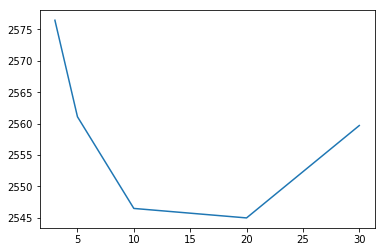

In [12]:
#numTree에 대한 관계 예측하기
params=[3,5,10,20,30]
metrics=[evaluate_rf(train_data, test_data, param, 4, 32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()

##### ∴ Optimized Value 'numTree' is 20

[2, 4, 5, 10, 20, 30]
[2690.6890808213907, 2526.0046028768757, 2461.6895994291103, 2199.8200254446247, 1868.1283889465003, 1610.2498602416445]


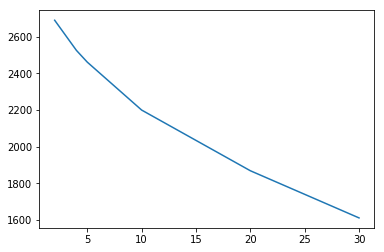

In [21]:
#maxDepth에 대한 관계 확인하기

params=[2,4,5,10,20,30] # 계속 줄어드는 그래프, 반등이 일어나지 않음. 값을 키우도록 한다.
##params=[10, 20,50, 100, 200]
##requirement failed: DecisionTree currently only supports maxDepth <= 30

metrics=[evaluate_rf(train_data, test_data, 20, param, 32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()

##### ∴ Optimized Value 'maxDepth' is 30

[20, 32, 50, 64, 128]
[1629.1428057410033, 1606.0959420448023, 1600.1497591654818, 1614.1738114843665, 1603.1584202737743]


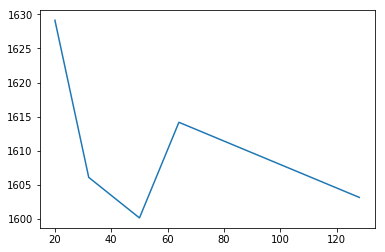

In [22]:
#maxBins에 대한 관계 확인하기

params=[20,32, 50, 64, 128]
metrics=[evaluate_rf(train_data, test_data, 20, 30, param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()

##### ∴ Optimized Value 'maxBins' is 50

[참고] : http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees
        
## 2) Gradient Boosted Tree
- DecisionTree를 반복적으로 Training
- 각 Instance값과 값을 계속 비교하면서, 오차를 줄여나감
- 

##### trainRegressor(data, categoricalFeaturesInfo, loss='leastSquaresError', numIterations=100, learningRate=0.1, maxDepth=3, maxBins=32)


###### Parameters:	
* data – Training dataset: RDD of LabeledPoint. Labels are real numbers.
* categoricalFeaturesInfo – Map storing arity of categorical features. An entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
* loss – Loss function used for minimization during gradient boosting. Supported values: “logLoss”, “leastSquaresError”, “leastAbsoluteError”. (default: “leastSquaresError”)
* numIterations – Number of iterations of boosting. (default: 100)
* learningRate – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
* maxDepth – Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). (default: 3)
* maxBins – Maximum number of bins used for splitting features. DecisionTree requires maxBins >= max categories. (default: 32)

In [ ]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
#from pyspark.mllib.util import MLUtils

# Load and parse the data file.
data = MLUtils.loadLibSVMFile(sc, "data/mllib/sample_libsvm_data.txt")
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GradientBoostedTrees model.
#  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
#         (b) Use more iterations in practice.
model = GradientBoostedTrees.trainClassifier(trainingData,
                                             categoricalFeaturesInfo={}, numIterations=3)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification GBT model:')
print(model.toDebugString())

# Save and load model
model.save(sc, "target/tmp/myGradientBoostingClassificationModel")
sameModel = GradientBoostedTreesModel.load(sc,
                                           "target/tmp/myGradientBoostingClassificationModel")

In [ ]:
# Gradient Boosted Tree 테스트 메소드
def evaluate_rf(train, test, numTrees, maxDepth, maxBins):
    model=RandomForest.trainRegressor(train, categoricalFeaturesInfo={}, numTrees=numTrees, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda p:p.features))
    actual=test.map(lambda p:p.label)
    tp=actual.zip(preds)
    rmse=np.sqrt(tp.map(lambda p:squared_error(p[0], p[1])).mean())
    return rmse